# Leading Edge Erosion GaSP and PPGasp Exploration

## [Training GaSPs](#training)
First, read in the data for training.  If we want to train PPGaSPs, go to [Training PPGaSPs](#trainingPP).

If we already trained the emulators, proceed to [Validate](#val)

In [1]:
import pandas as pd
data = pd.read_table('LHC220_ExpDataTable.txt',delimiter=',')

Then, inspect the table

In [2]:
data.head()

,Wind_Direction,Wind_Speed,Air_Density,BldPitch1,BldPitch2,BldPitch3,LSShftFxa,LSShftFya,LSShftFza,LSShftMxa,...,Blade2Region4,Blade2Region5,Blade2Region6,Blade3Region1,Blade3Region2,Blade3Region3,Blade3Region4,Blade3Region5,Blade3Region6,ErosionClass
0,11.897727,14.243182,1.187972,5.820897,5.820897,5.820897,603.372645,-1.480176,-3.451978,4180.139509,...,0.187500,0.111364,0.075000,0.107386,0.008523,0.412500,0.278409,0.470455,0.865909,light_moderate
1,9.238636,15.865909,1.192983,9.475813,9.475813,9.475813,525.595751,-10.190943,4.547302,4180.073270,...,0.055682,0.915909,0.625000,0.110795,0.065341,0.426136,0.394318,0.229545,0.547727,moderate
2,9.920455,5.743182,1.268710,0.000000,0.000000,0.000000,282.630901,-22.377370,-8.900686,689.634370,...,0.092045,0.697727,0.338636,0.158523,0.182386,0.382955,0.492045,0.956818,0.761364,light_moderate
3,5.965909,18.184091,1.244210,14.057100,14.057100,14.057100,454.267286,-1.667238,5.415940,4180.156382,...,0.492045,0.034091,0.193182,0.240341,0.101705,0.226136,0.023864,0.147727,0.465909,light
4,0.579545,18.415909,1.230290,0.000000,0.000000,0.000000,971.123981,13.969798,-22.057260,3683.609280,...,0.112500,0.220455,0.334091,0.055114,0.133523,0.487500,0.071591,0.506818,0.765909,moderate


Load the other packages, then load the file that contains the rankings of sensitive inputs for a given output.  Make a dictionary out of that information.

In [39]:
import numpy as np
from psimpy.emulator import ScalarGaSP
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [40]:
rank_data = open("Morris21_5T_index.txt","r+")
lines = rank_data.readlines()

rank_dict = {}
for line in lines:
    line = line.rstrip()
    shards = line.split(", ")
    rank_dict[shards[0]] = shards[1:]

Now, select some of the outputs to emulate, we will train those emulators and create a file that records the following information for all outputs:
- Output Name
- For 3 random training splits of the data, RMSE, Correlation Coefficient

We will pickle the best-fit emulator.

In [43]:
column_names = data.columns
selected_outputs = column_names[118:124]
print(selected_outputs)

Index(['B1N1Cl', 'B1N2Cl', 'B1N3Cl', 'B1N4Cl', 'B1N5Cl', 'B1N6Cl'], dtype='object')


In [45]:
import pickle

# Specify the number of times we will train the emulator
num_test = 3

# Specify the testing ratio
test_ratio = .05

# Select the column names
column_names = data.columns
selected_outputs = column_names[118:124]

# Create a list to house the information for the summary file, and the file ID
GaspSumFileID = "GaspSumFileID_1.txt";
summary_list = []


for out_name in selected_outputs:
    out_line = out_name + " Sensitive Inputs:"
    #summary_list = summary_list+[out_name]
    
    # Select the data column for the current output
    y = data[out_name].to_numpy()
    
    # Convert the sensitive inputs list into ints, and map them to the correct columns of the data matrix
    input_names = []
    iter = 0
    for i in rank_dict[out_name]:
        in_int = int(i)
        if in_int > 2:
            in_int = in_int+612
        input_names = input_names + [column_names[in_int]]
        out_line = out_line+" "+column_names[in_int]
        iter = iter+1
    summary_list = summary_list+[out_line+"\n"]
    
    # Select the inputs
    X = data[input_names].to_numpy()
    print("             Now training emulator for " + out_name)
    
    test_dict = {}
    scale_dict = {}
    ccs = []
    # We will train the emulator 3 times on different random selections of the training data
    for i in range(num_test):
        test_line = "Test#"+str(i+1)+": "
        print("                Training Test#"+str(i+1))
        # We will scale the inputs before trying to predict the outputs for best results;
        # But in order to avoid data leaks, first we will split the data, then scale the training data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train_sc = scaler.transform(X_train) # Transform the training data

        # Select the model
        emulator = ScalarGaSP(ndim=len(input_names),num_initial_values=2)

        # Fit the model
        emulator.train(design=X_train_sc, response=y_train)

        # Validate the model and use it to output the RMSE and the Correlation Coefficient
        validation = emulator.loo_validate()
    
        error = np.sqrt(mean_squared_error(validation[:,0],y_train))
        test_line = test_line + "RMSE = " + str(error)
        
        corr_coef = r2_score(validation[:,0],y_train) 
        ccs = ccs + [corr_coef]
        test_line = test_line + ", CorrCoef = " + str(corr_coef) +"\n"
        summary_list = summary_list + [test_line]
        
        # Save the emulators for each training
        test_dict[i] = emulator
        # Save the scaler for each training
        scale_dict[i] = scaler
    
    # Now we will pickle the emulator with the best Correlation Coefficient
    num = np.argmax(np.array(ccs))
    
    # Give the model a name
    mod_ID = out_name+"ScalarGaSP.pkl"
    # Open a file for writing
    with open(mod_ID, 'wb') as f:
        # Use the pickle.dump() function to serialize the machine learning model to the file
        pickle.dump(test_dict[num], f)

    # Close the file
    f.close()
    
    sc_ID = out_name+"StandardScaler.pkl"
    # Open a file for writing
    with open(sc_ID, 'wb') as f:
        # Use the pickle.dump() function to serialize the machine learning model to the file
        pickle.dump(scale_dict[num], f)

    # Close the file
    f.close()
        
    print("************************************************************************************************************************")
    print("************************************************************************************************************************")
    # Extract information about the range-parameters
    sourceFile = open('python.txt', 'w')
    print(test_dict[num].emulator,file=sourceFile)
    sourceFile.close()
    file = open("python.txt", "r")
    iter = 0;
    while True:
        content=file.readline()
        if not content:
            break
        iter = iter+1;
    file.close()
    a = iter
    file = open("python.txt", "r")
    iter = 0;
    while True:
        content=file.readline()
        if not content:
            break
        if iter == a-3:
            dataline = content
        iter = iter+1;
    file.close()
    import os
    os.remove("python.txt")
    dataline = dataline.split()
    range_parms = "";
    iter = 0;
    for i in dataline[2:]:
        range_parms= range_parms+" "+i
        iter = iter+1
    
    print("************************************************************************************************************************")
    
    summary_list = summary_list+["*************************************************************************************************************\n"]
    summary_list = summary_list+["***"+range_parms+"\n"]
    summary_list = summary_list+["*************************************************************************************************************\n"]
    

indFile = open(GaspSumFileID, "w")
indFile.writelines(summary_list)
indFile.close()


             Now training emulator for B1N1Cl
                Training Test#1
The upper bounds of the range parameters are 70.75415 66.79136 68.09289 68.85004 69.98524 67.40438 
The initial values of range parameters are 1.415083 1.335827 1.361858 1.377001 1.399705 1.348088 
Start of the optimization  1  : 
The number of iterations is  41 
 The value of the  marginal posterior  function is  -15.94328 
 Optimized range parameters are 0.5055438 15.83082 10.09962 68.85004 1.67048 3.270965 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 6.81824 6.436365 6.561787 6.63475 6.744144 6.495438 
Start of the optimization  2  : 
The number of iterations is  22 
 The value of the  marginal posterior  function is  -16.5979 
 Optimized range parameters are 0.4412349 8.900072 36.65293 12.96201 1.638146 8.569136 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
                Training Test#2
The upper bounds of the range parameters are 80.02959 

## [Training PPGaSPs](#trainingPP)

In [59]:
import numpy as np
from psimpy.emulator import PPGaSP
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [71]:
import pandas as pd
data = pd.read_table('LHC220_ExpDataTable.txt',delimiter=',')

In [72]:
rank_data = open("Morris21_5T_index.txt","r+")
lines = rank_data.readlines()

rank_dict = {}
for line in lines:
    line = line.rstrip()
    shards = line.split(", ")
    rank_dict[shards[0]] = shards[1:]

In [62]:
# Practice merging lists
list1 = [1,2,3]
list2 = [1,4,5]
list3 = [2,6,7]
listolist = [list1,list2,list3]
merg = []
for l in listolist:
    set1 = set(merg)
    set2 = set(l)
    merg = list(set1.union(set2))
print(merg)

[1, 2, 3, 4, 5, 6, 7]


In [88]:
column_names = data.columns
print(column_names[124:130])

Index(['B2N1Cl', 'B2N2Cl', 'B2N3Cl', 'B2N4Cl', 'B2N5Cl', 'B2N6Cl'], dtype='object')


In [89]:
import pickle

# Specify the number of times we will train the emulator
num_test = 3

# Specify the testing ratio
test_ratio = .1

# Select the columns to be trained together as key-pairs in dictionary
column_names = data.columns
PPdict = {}
PPdict["B2Cls"] = [column_names[124:130]]
PPdict_keys = list(PPdict.keys())

# Create a list to house the information for the summary file, and the file ID
GaspSumFileID = "PPGaspSumFileID_1.txt";
summary_list = []


outiter = 0
for out_gk in PPdict_keys:
    out_line = out_gk + " Sensitive Inputs:"
    
    # Select the data columns for the current outputs
    outs = PPdict[out_gk][0]
    y = data[outs].to_numpy()
    
    # For each output, convert the sensitive inputs list into ints, and map them to the correct columns of the data matrix
    merged = []
    for j in outs:
        input_ints = []
        for i in rank_dict[j]:
            in_int = int(i)
            if in_int > 2:
                in_int = in_int+612
            input_ints = input_ints + [column_names[in_int]]
            
        set1 = set(merged)
        set2 = set(input_ints)
        merged = list(set1.union(set2))
    
    input_names = []
    for i in merged:
        out_line = out_line+" "+i
        input_names = input_names+[i]
    
    summary_list = summary_list+[out_line+"\n"]
    
    # Select the inputs
    X = data[input_names].to_numpy()
    print("             Now training emulator for " + out_gk)
    
    test_dict = {}
    scale_dict = {}
    ccs = []
    # We will train the emulator 3 times on different random selections of the training data
    for i in range(num_test):
        test_n = "Test#"+str(i+1)+"\n"
        summary_list = summary_list+[test_n]
        print("                Training Test#"+str(i+1))
        
        # We will scale the inputs before trying to predict the outputs for best results;
        # But in order to avoid data leaks, first we will split the data, then scale the training data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train_sc = scaler.transform(X_train) # Transform the training data
        X_test_sc = scaler.transform(X_test) 
        
        # Select the model
        emulator = PPGaSP(ndim=len(input_names),num_initial_values=2)

        # Fit the model
        emulator.train(design=X_train_sc, response=y_train)

        # Validate the model and use it to output the RMSE and the Correlation Coefficient
        predictions = emulator.predict(X_test_sc)
        
        cc_sum = 0
        iter = 0
        for j in outs:
            test_line = j
            
            error = np.sqrt(mean_squared_error(predictions[:,iter,0],y_test[:,iter]))
        
            test_line = test_line + ": RMSE = " + str(error)
        
            corr_coef = r2_score(predictions[:,iter,0],y_test[:,iter]) 
            
            test_line = test_line + ", CorrCoef = " + str(corr_coef) +"\n"
            cc_sum = cc_sum + corr_coef
            iter = iter+1
            summary_list = summary_list + [test_line]
        cc_avg = cc_sum/len(outs)
        ccs = ccs + [cc_avg]
        # Save the emulators for each training
        test_dict[i] = emulator
        # Save the scaler for each training
        scale_dict[i] = scaler
    
    # Now we will pickle the emulator with the best Correlation Coefficient
    num = np.argmax(np.array(ccs))
    
    # Give the model a name
    mod_ID = out_gk+"PPGaSP.pkl"
    # Open a file for writing
    with open(mod_ID, 'wb') as f:
        # Use the pickle.dump() function to serialize the machine learning model to the file
        pickle.dump(test_dict[num], f)

    # Close the file
    f.close()
    
    sc_ID = out_gk+"StandardScaler.pkl"
    # Open a file for writing
    with open(sc_ID, 'wb') as f:
        # Use the pickle.dump() function to serialize the machine learning model to the file
        pickle.dump(scale_dict[num], f)

    # Close the file
    f.close()
        
    print("************************************************************************************************************************")
    
    # Extract information about the range-parameters
    sourceFile = open('python.txt', 'w')
    print(test_dict[num].emulator,file=sourceFile)
    sourceFile.close()
    file = open("python.txt", "r")
    iter = 0;
    while True:
        content=file.readline()
        if not content:
            break
        iter = iter+1;
    file.close()
    a = iter
    file = open("python.txt", "r")
    iter = 0;
    while True:
        content=file.readline()
        if not content:
            break
        if iter == a-3:
            dataline = content
        iter = iter+1;
    file.close()
    import os
    os.remove("python.txt")
    dataline = dataline.split()
    range_parms = "";
    iter = 0;
    for i in dataline[2:]:
        range_parms= range_parms+" "+i
        iter = iter+1
    
    print("************************************************************************************************************************")
    
    summary_list = summary_list+["*************************************************************************************************************\n"]
    summary_list = summary_list+["***"+range_parms+"\n"]
    summary_list = summary_list+["*************************************************************************************************************\n"]
    
    outiter = outiter +1
    if outiter == 4:
        break

indFile = open(GaspSumFileID, "w")
indFile.writelines(summary_list)
indFile.close()

             Now training emulator for B2Cls
                Training Test#1
The upper bounds of the range parameters are 153.4629 156.5291 159.3083 156.0591 159.3268 163.179 164.6298 158.2013 156.7591 157.0105 159.0515 
The initial values of range parameters are 3.069259 3.130581 3.186166 3.121182 3.186536 3.263579 3.292596 3.164026 3.135181 3.14021 3.18103 
Start of the optimization  1  : 
The number of iterations is  36 
 The value of the  marginal posterior  function is  188.4481 
 Optimized range parameters are 21.99689 4.132911 9.891281 4.707386 5.848037 6.83572 0.5707839 12.01892 16.24065 2.651863 9.578166 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 27.14004 27.68229 28.1738 27.59918 28.17707 28.85833 29.11491 27.97802 27.72296 27.76743 28.12839 
Start of the optimization  2  : 
The number of iterations is  38 
 The value of the  marginal posterior  function is  188.4481 
 Optimized range parameters are 21.99689 4.132911 9.8

## [Validate](#val)
Here we can load in the pickled GaSP and PPGaSP models and compare their performance on verification data.

Note that the column names in the verification data must line up with the column names in the GaspSumFileID file.

Also, must make sure that the columns are in the same units in the verification table as in the training table.

### Validation of a GaSP

In [83]:
# Start by reading in the Summary File, the DataTable, and the Model
import re
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

GaspSumFileID = "GaspSumFileID_1.txt";
sum_data = open(GaspSumFileID,"r+")
lines = sum_data.readlines()
sum_data.close()
outs_dict = {}
for line in lines:
    x = re.search("^Test",line)
    if x != None:
        continue
    x = re.search("^[**]",line)
    if x != None:
        continue
    shards = line.split()
    outs_dict[shards[0]] = shards[3:]

OutskeysList = list(outs_dict.keys())

We want to see what Outputs we have emulators for so we can select one output

In [84]:
print(OutskeysList)

['B1N1Cl', 'B1N2Cl', 'B1N3Cl', 'B1N4Cl', 'B1N5Cl', 'B1N6Cl']


In [85]:
num = 4; # Number of the selected output
tableID = '4Class_ExpDataTable.txt';
#tableID = "LHC220_ExpDataTable.txt";
data = pd.read_table(tableID,delimiter=',')
data.Air_Density = data.Air_Density.to_numpy()*10**(-3)

X = data[outs_dict[OutskeysList[num]]].to_numpy()

# One must rescale the inputs
scfile_ID = OutskeysList[num]+"StandardScaler.pkl"
with open(scfile_ID, 'rb') as f:
    # Use the pickle.load() function to deserialize the machine learning model from the file
    pickled_sc = pickle.load(f)
# Close the file
f.close()

X_sc = pickled_sc.transform(X) # Transform the training data

y = data[OutskeysList[num]].to_numpy()

emfile_ID = OutskeysList[num]+"ScalarGaSP.pkl"
with open(emfile_ID, 'rb') as f:
    # Use the pickle.load() function to deserialize the machine learning model from the file
    pickled_em = pickle.load(f)
# Close the file
f.close()

Run some verification

RMSE: 0.012634807580425655
Correlation Coefficient: 0.9968573379497803


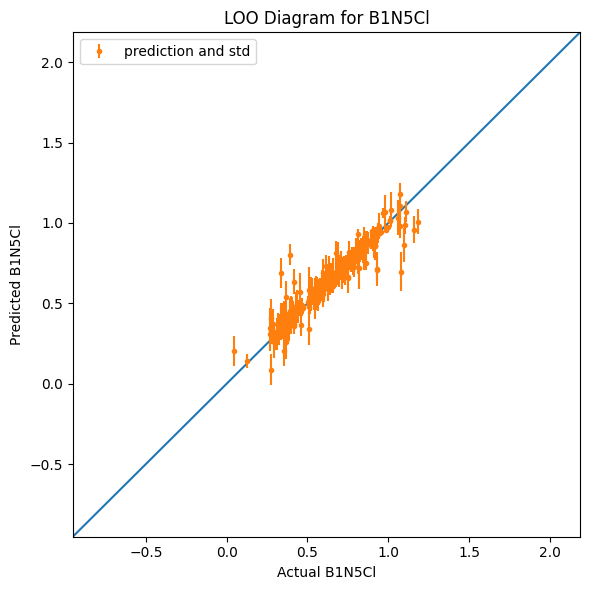

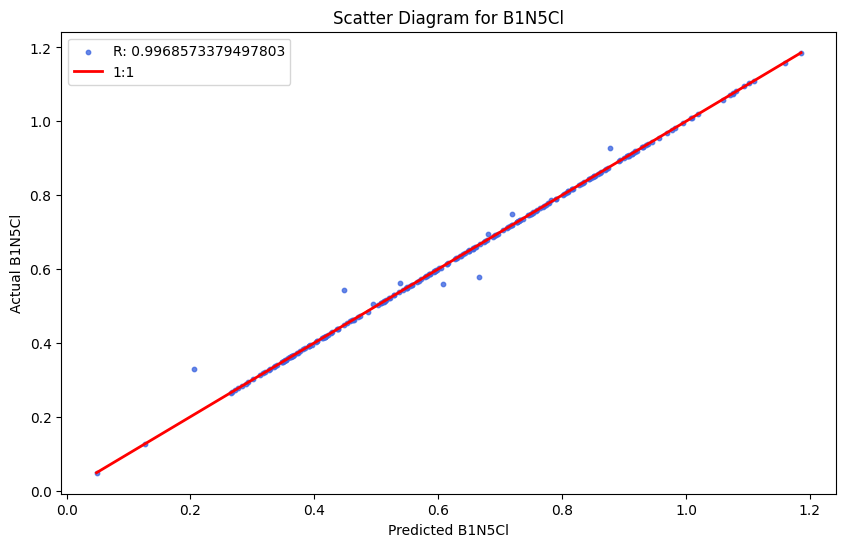

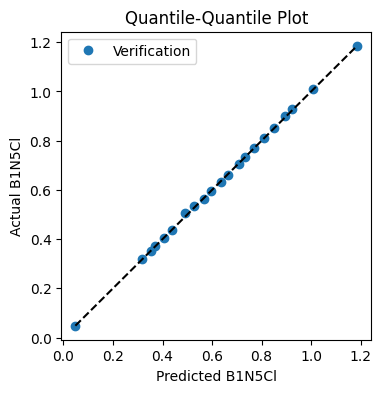

In [86]:
# Validate the model
validation = pickled_em.loo_validate()
name = OutskeysList[num]

# Plot the validation
fig , ax = plt.subplots(figsize=(6,6))
yval = pickled_em.response # This will extract the original responses used to train the model
yaxtext = "Actual "+name
xaxtext = "Predicted "+name
ax.set_xlabel(yaxtext)
ax.set_ylabel(xaxtext)
ax.set_xlim(np.min(y)-1,np.max(y)+1)
ax.set_ylim(np.min(y)-1,np.max(y)+1)
ttl = "LOO Diagram for "+name
ax.set_title(ttl)
_ = ax.plot([np.min(y)-1,np.max(y)+1], [np.min(y)-1,np.max(y)+1])
_ = ax.errorbar(yval, validation[:,0], validation[:,1], fmt='.', linestyle='', label='prediction and std')
_ = plt.legend()
plt.tight_layout()

# Predict the outputs using the GaSp
predicted = pickled_em.predict(X_sc)
predicted = predicted[:,0] # Select the mean prediction

# Calculate R factor and mean-square-error
error= np.sqrt(mean_squared_error(predicted,y))

corr_coef = r2_score(predicted,y)

print('RMSE:',error)
print('Correlation Coefficient:',corr_coef)

# Plot the Scatter Diagram
l1 = "R: "+str(corr_coef)
fig2, ax = plt.subplots(figsize=(10,6))
ax.scatter(predicted, y, color="royalblue", label=l1, s=10,alpha = 0.8)
ax.plot([y.min(),y.max()],[y.min(),y.max()],color = "red", label = "1:1", linewidth=2)
ax.set_xlabel(xaxtext)
ax.set_ylabel(yaxtext)
ttl = "Scatter Diagram for "+name
ax.set_title(ttl)
ax.legend()

fig3, ax = plt.subplots(figsize=(4,4))
a = predicted
b = y

percs = np.linspace(0,100,21)
qn_a = np.percentile(a, percs)
qn_b = np.percentile(b, percs)

plt.plot(qn_a,qn_b, ls="", marker="o",label = "Verification")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x,x, color="k", ls="--")
plt.title("Quantile-Quantile Plot")
plt.xlabel(xaxtext)
plt.ylabel(yaxtext)
plt.legend()

Cycle Through all of the predictable columns, create a dataset that stores the RMSE and the Correlation Coefficient for each output in the testing data-set.

In [56]:
# Start by reading in the Summary File, the DataTable, and the Model
import re
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# FILE ADDRESS
fID = 'ScalarGaSP_predicts1.txt'

GaspSumFileID = "GaspSumFileID_1.txt";
sum_data = open(GaspSumFileID,"r+")
lines = sum_data.readlines()
sum_data.close()
outs_dict = {}
for line in lines:
    x = re.search("^Test",line)
    if x != None:
        continue
    x = re.search("^[**]",line)
    if x != None:
        continue
    shards = line.split()
    outs_dict[shards[0]] = shards[3:]

OutskeysList = list(outs_dict.keys())

# Grab the Data
tableID = '4Class_ExpDataTable.txt';
#tableID = "LHC220_ExpDataTable.txt";
data = pd.read_table(tableID,delimiter=',')
data.Air_Density = data.Air_Density.to_numpy()*10**(-3)


datadict = {}
names = []
rMsEs = []
cc = []
for name in OutskeysList:
    names = names + [name]
    # Extract the Predictors
    X = data[outs_dict[name]].to_numpy()
    print(name)
    # One must rescale the inputs, so load the scaler
    scfile_ID = name+"StandardScaler.pkl"
    with open(scfile_ID, 'rb') as f:
        # Use the pickle.load() function to deserialize the machine learning model from the file
        pickled_sc = pickle.load(f)
    # Close the file
    f.close()
             
    X_sc = pickled_sc.transform(X) # Transform the training data

    y = data[name].to_numpy()
    
    # Prepare to make predictions
    emfile_ID = name+"ScalarGaSP.pkl"
    with open(emfile_ID, 'rb') as f:
        # Use the pickle.load() function to deserialize the machine learning model from the file
        pickled_em = pickle.load(f)
    # Close the file
    f.close()
             
    # Predict the outputs using the GaSp
    predicted = pickled_em.predict(X_sc)
    predicted = predicted[:,0] # Select the mean prediction

    # Calculate R factor and mean-square-error
    error= np.sqrt(mean_squared_error(predicted,y))

    corr_coef = r2_score(predicted,y)

    print('RMSE:',error)
    print('Correlation Coefficient:',corr_coef)
    
    rMsEs = rMsEs + [error]
    cc = cc + [corr_coef]

datadict["RMSEs"] = rMsEs
datadict["CorrCoefs"] = cc
             
import pandas as pd
df = pd.DataFrame(datadict, index=names)
df.to_csv(fID, index=True)
    

B1N1Cl
RMSE: 0.07553238043549014
Correlation Coefficient: 0.9418458401199066
B1N2Cl
RMSE: 0.011814496203884155
Correlation Coefficient: 0.9985536122102245
B1N3Cl
RMSE: 0.010855706879612645
Correlation Coefficient: 0.9975666308584509
B1N4Cl
RMSE: 0.03016611418359693
Correlation Coefficient: 0.9810870165345768
B1N5Cl
RMSE: 0.012634807580425655
Correlation Coefficient: 0.9968573379497803
B1N6Cl
RMSE: 0.03185237753886986
Correlation Coefficient: 0.9824994411686795


### Validate the PPGaSP

In [75]:
# Start by reading in the Summary File, the DataTable, and the Model
import re
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

GaspSumFileID = "PPGaspSumFileID_1.txt";
sum_data = open(GaspSumFileID,"r+")
lines = sum_data.readlines()
sum_data.close()
outs_dict = {}
iter = -1
for line in lines:
    subdict = {}
    x = re.search("Sensitive Inputs",line)
    iter = iter+1
    if x == None:
        continue
    shards = line.split()
    subdict["Inputs"] = shards[3:]
    
    predict_targets = []
    t = 0
    subiter = 1
    while t == 0:
        subline = lines[iter+subiter]
        xx = re.search("^Test#2",subline)
        if xx != None:
            t = 1
            continue
        xx = re.search("^Test",subline)
        if xx != None:
            subiter = subiter+1
            continue
        xx = re.search("[(*)]",subline)
        if xx != None:
            t = 1
            continue
        sshards = subline.split()
        predict_targets = predict_targets + [sshards[0].strip(':')]
        subiter = subiter + 1
    
    subdict["Targets"] = predict_targets
    outs_dict[shards[0]] = subdict

OutskeysList = list(outs_dict.keys())

In [76]:
# Look at the options for outputs we can explore
print(OutskeysList)
print(outs_dict[OutskeysList[0]])

['B1Cls']
{'Inputs': ['Blade1Region6', 'Blade3Region6', 'Air_Density', 'Blade1Region4', 'Blade1Region5', 'Wind_Direction', 'Blade1Region3', 'Wind_Speed', 'Blade1Region1', 'Blade2Region6', 'Blade1Region2'], 'Targets': ['B1N1Cl', 'B1N2Cl', 'B1N3Cl', 'B1N4Cl', 'B1N5Cl', 'B1N6Cl']}


In [77]:
num = 0; # Numbers of the selected output
tableID = '4Class_ExpDataTable.txt'; # The data set we will test on
#tableID = "LHC220_ExpDataTable.txt";
data = pd.read_table(tableID,delimiter=',')
data.Air_Density = data.Air_Density.to_numpy()*10**(-3) #Special conversion for the 4Class dataset 

outg_dict = outs_dict[OutskeysList[num]]
X = data[outg_dict['Inputs']].to_numpy()

# One must rescale the inputs
scfile_ID = OutskeysList[num]+"StandardScaler.pkl"
with open(scfile_ID, 'rb') as f:
    # Use the pickle.load() function to deserialize the machine learning model from the file
    pickled_sc = pickle.load(f)
# Close the file
f.close()

X_sc = pickled_sc.transform(X) # Transform the training data

y = data[outg_dict['Targets']].to_numpy()

emfile_ID = OutskeysList[num]+"PPGaSP.pkl"
with open(emfile_ID, 'rb') as f:
    # Use the pickle.load() function to deserialize the machine learning model from the file
    pickled_em = pickle.load(f)
# Close the file
f.close()

B1N1Cl RMSE: 0.12888015505747272
B1N1Cl Correlation Coefficient: 0.8107789012111852
B1N2Cl RMSE: 0.12658669166562184
B1N2Cl Correlation Coefficient: 0.8415039394875229
B1N3Cl RMSE: 0.1005973599965685
B1N3Cl Correlation Coefficient: 0.7820295986607677
B1N4Cl RMSE: 0.1385080610054421
B1N4Cl Correlation Coefficient: 0.6027069532754601
B1N5Cl RMSE: 0.14700120805326275
B1N5Cl Correlation Coefficient: 0.44277217714181805
B1N6Cl RMSE: 0.13637332799448798
B1N6Cl Correlation Coefficient: 0.4922139214990766


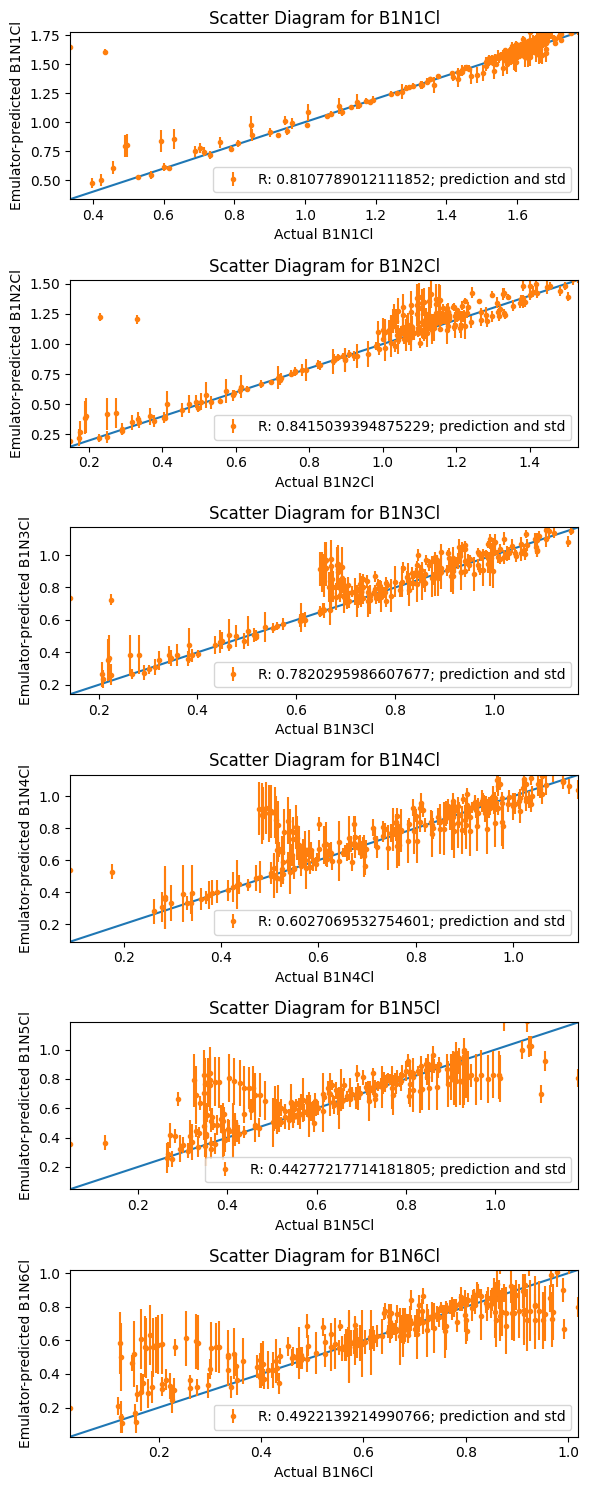

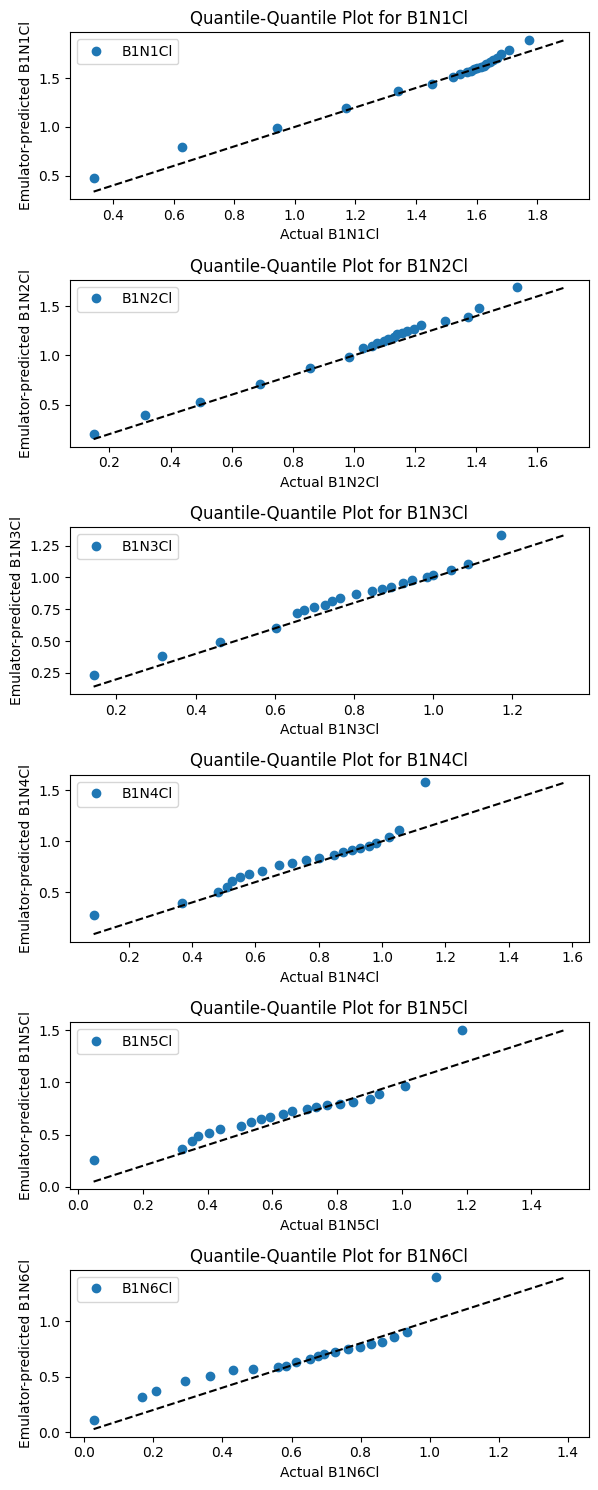

In [78]:
# Validate the model
import matplotlib.pyplot as plt

# For each target covered by the PPGaSP we will plot the QQ plot and the Scatter Diagram

# Predict the outputs using the GaSp
predictions = pickled_em.predict(X_sc)

fig, ax = plt.subplots(len(outg_dict['Targets']), 1, figsize=(6,15))

for i in range(len(outg_dict['Targets'])):
    names = outg_dict['Targets']
    name = names[i]
    # Calculate R factor and mean-square-error
    error= np.sqrt(mean_squared_error(predictions[:,i,0],y[:,i]))

    corr_coef = r2_score(predictions[:,i,0],y[:,i])

    print(name+' RMSE:',error)
    print(name+' Correlation Coefficient:',corr_coef)
    l1 = "R: "+str(corr_coef)+"; prediction and std"
    ax[i].set_xlabel("Actual "+name)
    ax[i].set_ylabel("Emulator-predicted "+name)
    ax[i].set_xlim(np.min(y[:,i]),np.max(y[:,i]))
    ax[i].set_ylim(np.min(y[:,i]),np.max(y[:,i]))
    ttl = "Scatter Diagram for "+name
    ax[i].set_title(ttl)

    _ = ax[i].plot([np.min(y[:,i]),np.max(y[:,i])], [np.min(y[:,i]),np.max(y[:,i])])
    _ = ax[i].errorbar(y[:,i], predictions[:,i,0], predictions[:,i,3], fmt='.', linestyle='', label=l1)
    _ = ax[i].legend()
    

plt.tight_layout()

fig, ax = plt.subplots(len(outg_dict['Targets']), 1, figsize=(6,15))

for i in range(len(outg_dict['Targets'])):
    names = outg_dict['Targets']
    name = names[i]
    b = predictions[:,i,0]
    a = y[:,i]

    percs = np.linspace(0,100,21)
    qn_a = np.percentile(a, percs)
    qn_b = np.percentile(b, percs)

    _ = ax[i].plot(qn_a,qn_b, ls="", marker="o",label = name)

    x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
    _ = ax[i].plot(x,x, color="k", ls="--")
    ax[i].set_title("Quantile-Quantile Plot for "+name )
    ax[i].set_xlabel("Actual "+name)
    ax[i].set_ylabel("Emulator-predicted "+name)
    _ = ax[i].legend()
plt.tight_layout()

Cycle Through all of the predictable columns, create a dataset that stores the RMSE and the Correlation Coefficient for each output group in the testing data-set.

In [81]:
# Start by reading in the Summary File, the DataTable, and the Model
import re
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Save the results table as 
fID = "PPGaSP_predict1.txt"

GaspSumFileID = "PPGaspSumFileID_1.txt";
sum_data = open(GaspSumFileID,"r+")
lines = sum_data.readlines()
sum_data.close()
outs_dict = {}
iter = -1
for line in lines:
    subdict = {}
    x = re.search("Sensitive Inputs",line)
    iter = iter+1
    if x == None:
        continue
    shards = line.split()
    subdict["Inputs"] = shards[3:]
    
    predict_targets = []
    t = 0
    subiter = 1
    while t == 0:
        subline = lines[iter+subiter]
        xx = re.search("^Test#2",subline)
        if xx != None:
            t = 1
            continue
        xx = re.search("^Test",subline)
        if xx != None:
            subiter = subiter+1
            continue
        xx = re.search("[(*)]",subline)
        if xx != None:
            t = 1
            continue
        sshards = subline.split()
        predict_targets = predict_targets + [sshards[0].strip(':')]
        subiter = subiter + 1
    
    subdict["Targets"] = predict_targets
    outs_dict[shards[0]] = subdict

OutskeysList = list(outs_dict.keys())

# Grab the Data
tableID = '4Class_ExpDataTable.txt';
#tableID = "LHC220_ExpDataTable.txt";
data = pd.read_table(tableID,delimiter=',')
data.Air_Density = data.Air_Density.to_numpy()*10**(-3)

datadict = {}
names = []
rMsEs = []
cc = []

for groupname in OutskeysList:
    outg_dict = outs_dict[groupname]
    print(groupname)
    X = data[outg_dict['Inputs']].to_numpy()

    # One must rescale the inputs
    scfile_ID = groupname+"StandardScaler.pkl"
    with open(scfile_ID, 'rb') as f:
        # Use the pickle.load() function to deserialize the machine learning model from the file
        pickled_sc = pickle.load(f)
    # Close the file
    f.close()

    X_sc = pickled_sc.transform(X) # Transform the training data

    y = data[outg_dict['Targets']].to_numpy()

    emfile_ID = groupname+"PPGaSP.pkl"
    with open(emfile_ID, 'rb') as f:
        # Use the pickle.load() function to deserialize the machine learning model from the file
        pickled_em = pickle.load(f)
    # Close the file
    f.close()
    
    predictions = pickled_em.predict(X_sc)
    
    predictions = predictions[:,:,0]
    iter = 0
    for name in outg_dict['Targets']:
        names = names + [name]
    
        # Calculate R factor and mean-square-error
        error= np.sqrt(mean_squared_error(predictions[:,iter],y[:,iter]))

        corr_coef = r2_score(predictions[:,iter],y[:,iter])

        print(name+' RMSE:',error)
        print(name+' Correlation Coefficient:',corr_coef)

        rMsEs = rMsEs + [error]
        cc = cc + [corr_coef]
        iter = iter+1

datadict["RMSEs"] = rMsEs
datadict["CorrCoefs"] = cc
             
import pandas as pd
df = pd.DataFrame(datadict, index=names)
df.to_csv(fID, index=True)

B1Cls
B1N1Cl RMSE: 0.12888015505747272
B1N1Cl Correlation Coefficient: 0.8107789012111852
B1N2Cl RMSE: 0.12658669166562184
B1N2Cl Correlation Coefficient: 0.8415039394875229
B1N3Cl RMSE: 0.1005973599965685
B1N3Cl Correlation Coefficient: 0.7820295986607677
B1N4Cl RMSE: 0.1385080610054421
B1N4Cl Correlation Coefficient: 0.6027069532754601
B1N5Cl RMSE: 0.14700120805326275
B1N5Cl Correlation Coefficient: 0.44277217714181805
B1N6Cl RMSE: 0.13637332799448798
B1N6Cl Correlation Coefficient: 0.4922139214990766
